# Reconstructing Images With an Autoencoder

### [MNIST](http://yann.lecun.com/exdb/mnist/)

- database of handwritten digits (28x28 images)
- training set: 60000 samples
- test set: 10000 samples


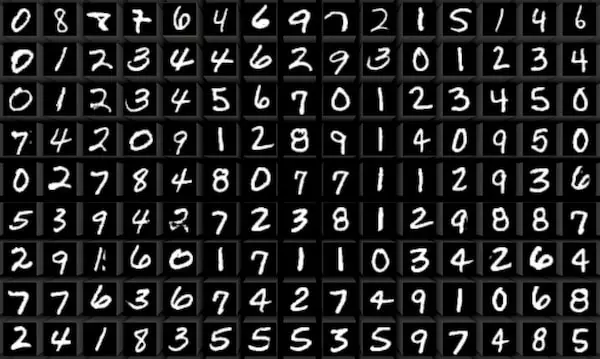

## Dataset

Download the MNIST dataset and split it to train and test sets:

In [ ]:
import torch
import numpy as np
from sklearn.datasets import fetch_openml


def download_MNIST():
  x, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

  # split to train and test:
  x_train, y_train = x[0:60000], y[0:60000]
  x_test, y_test = x[60000:70000], y[60000:70000]

  # transform np.ndarrays to torch.Tensor:
  x_train = torch.from_numpy(np.reshape(x_train, (len(x_train), 28, 28)).astype(np.float32))
  y_train = torch.from_numpy(y_train.astype(int))
  x_test = torch.from_numpy(np.reshape(x_test, (len(x_test), 28, 28)).astype(np.float32))
  y_test = torch.from_numpy(y_test.astype(int))

  return (x_train, y_train, x_test, y_test)

x_train, y_train, x_test, y_test = download_MNIST()

Get familiar with the data format:

In [ ]:
# x_train contains values of the pixel values of the image in this format:
# [sample1, sample2, ... sampleN]
# where sampleA == [ [ row1_col1_pixel, row1_col2_pixel, ... row1_colK_pixel ],
#                    ...
#                    [ rowL_col1_pixel, rowL_col2_pixel, ... rowL_colK_pixel ],
#

print(f'Num of samples in the train set: {len(x_train)}')
# all images have the same size, we can just look at the first one to get the dimensions:
print(f'Image shape: {len(x_train[0])}x{len(x_train[0][0])} pixels ({len(x_train[0])*len(x_train[0][0])})')

## Data Preparation

### Normalise the data:

**Min-Max scaling**: shifts the input values to a range between 0 and 1 (a common practice to use when the input data follows a normal distribution).

```
      X - X_min
X' = -------------
     X_max - X_min
```
Pixels == RGB values from the (0, 255) interval.

---

We can substitute 

```
      X - 0
X' = --------
     255 - 0
```

for

```
      X
X' = ----
     255
```

In [ ]:
# normalise each pixel value:
x_train = x_train/ 255
x_test = x_test/ 255

In [ ]:
# squash the pictures from the 28x28 matrix format to a single list:
input_train = x_train.reshape([-1, 28*28])
input_test = x_test.reshape([-1, 28*28])

print(f'shape x_train \t\t {x_train.shape}')
print(f'shape x_test \t\t {x_test.shape}')
print(f'shape input_train \t {input_train.shape}')
print(f'shape input_test \t {input_test.shape}')

Look at few samples from the dataset:

In [ ]:
import matplotlib.pyplot as plt

def plot_row(images, show_n=10, image_reshape=False):
  for items_idx, items in enumerate(images):
    items = np.array(items)

    # for the case when image is as a list of size 784 instead of matrix of 
    # size 28x28:
    if items.ndim == 1:
      items = np.expand_dims(items, axis=0)

    if len(items) > show_n:
      selected = np.random.choice(len(items), show_n, replace=False)
      items = items[selected]

    # for the case when image is as a list of size 784 instead of matrix of 
    # size 28x28:
    if image_reshape:
      items = items.reshape([-1, 28, 28])

    plt.figure(figsize=(len(items) * 1.5, 2))
    for image_idx, image in enumerate(items):
      plt.subplot(1, len(items), image_idx + 1)
      plt.imshow(image, cmap='gray', vmin=image.min(), vmax=image.max())
      plt.axis('off')

      plt.tight_layout()

# plot random images from the train and test set:
plot_row([x_train, x_test])

# Training

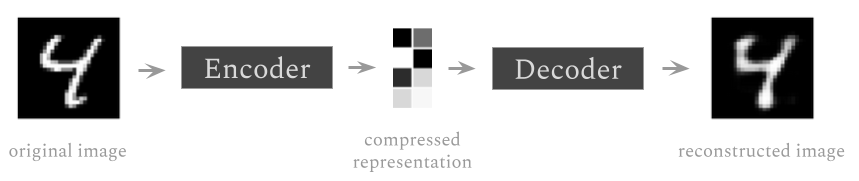

In [ ]:
from torch import nn

################################
# TODO: Add the embedding size #
################################
encoding_size = # TODO

model = nn.Sequential(
    nn.Linear(28*28, encoding_size),
    nn.ReLU(),
    nn.Linear(encoding_size, 28*28),
    nn.Sigmoid()
    )
###########################################################################
# TODO: You can play around with the architecture (add/ remove layers and #
# activation functions). See what gives you the best results and          #
# simultaneously does not slow down the training too much.                #
###########################################################################

print(f'Model structure \n\n {model}')

Check how the untrained AutoEncoder currently behaves on the test set:

In [ ]:
with torch.no_grad():
  output_test = model(input_test)

plot_row([input_test.float(), output_test], image_reshape=True)

Train the AutoEncoder using the stochastic gradient descent:

In [ ]:
from torch import optim

def eval_mse(y_pred, y_true):
  """
  Evaluates Mean Square Error (MSE) between the torch.Tensor prediction samples
  y_pred and numpy array of floats y_true (ground truth samples).
  """

  with torch.no_grad():
      criterion = nn.MSELoss()
      loss = criterion(y_pred, y_true)

  return float(loss)

def stochastic_gradient_descent(net, input_train, input_test, n_epochs=10, batch_size=32):
  """
  Trains autoencoder network with stochastic gradient descent with Adam
  optimizer.

  net: ANN object (nn.Module)
  input_train: vectorized torch.Tensor input images from train set
  input_test: vectorized torch.Tensor input images from test set
  """

  loss_fn = nn.MSELoss()
  optimizer = optim.Adam(net.parameters())
  # placeholder for the loss
  track_loss = []

  print('Epoch', '\t', 'Loss train', '\t', 'Loss test')
  for i in range(n_epochs):
    shuffle_idx = np.random.permutation(len(input_train))
    batches = torch.split(input_train[shuffle_idx], batch_size)

    for batch in batches:

      output_train = net(batch)
      loss = loss_fn(output_train, batch)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # keep track of the loss at each epoch
      track_loss += [float(loss)]

    loss_epoch = f'{i + 1} / {n_epochs}'
    with torch.no_grad():
      output_train = net(input_train)
      loss_train = loss_fn(output_train, input_train)
      loss_epoch += f'\t {loss_train:.4f}'

      output_test = net(input_test)
      loss_test = loss_fn(output_test, input_test)
      loss_epoch += f'\t\t {loss_test:.4f}'

    print(loss_epoch)

  # print final loss
  loss_mse = f'\nMSE\t {eval_mse(output_train, input_train):0.4f}'
  loss_mse += f'\t\t {eval_mse(output_test, input_test):0.4f}'
  print(loss_mse)

  # plot the loss
  step = int(np.ceil(len(track_loss)/ 500))
  x_range = np.arange(0, len(track_loss), step)
  plt.figure()
  plt.plot(x_range, track_loss[::step], 'C0')
  plt.xlabel('Iterations')
  plt.ylabel('Loss')
  plt.xlim([0, None])
  plt.ylim([0, None])
  plt.show()

In [ ]:
#########################################
# TODO: Choose according to your model. #
#########################################
n_epochs = # TODO
batch_size = # TODO

stochastic_gradient_descent(model, input_train, input_test, n_epochs=n_epochs, batch_size=batch_size)

Visualise the reconstructed images:

In [ ]:
with torch.no_grad():
  output_test = model(input_test)

plot_row([input_test[:10], output_test[:10]], image_reshape=True)

## Get the Embeddings of Images

To get the embeddings we need to work only with the Encoder part of our AutoEncoder.

In [ ]:
###############################################################
# TODO: split your AutoEncoder to Encoder and Decoder part.   #
# Hint: It depends on the architecture you specified earlier. #
###############################################################
encoder = model[#TODO]
decoder = model[#TODO]

print(f'Autoencoder: \n {model}\n')
print(f'Encoder part: \n {encoder}\n')
print(f'Decoder part: \n {decoder}\n')

In [ ]:
##############################################################################
# TODO: Use the Encoder to get the embeddings of few samples of your choice. #
##############################################################################